# MLP Tagger Baseline

Train a basline MLP model for tagging using graph-level features as the number of nodes and total energy.
Having a baseline withough utilizing the positional information is valuable for showing if CNN and GNN approaches provide additional value. The baseline could be further improved by engineering graph-level features utilizing the structural information, for example centrality metrics.

In [1]:
import uproot
import numpy as np

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from matplotlib import rcParams

tf.random.set_seed(42)

In [21]:
filename = "data/trackster_tags_10ke_pion.root"
tracksters = uproot.open({filename: "tracksters"})

In [22]:
tracksters.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
nvertices_x          | int32_t                  | AsDtype('>i4')
vertices_x           | double[]                 | AsJagged(AsDtype('>f8'))
nvertices_y          | int32_t                  | AsDtype('>i4')
vertices_y           | double[]                 | AsJagged(AsDtype('>f8'))
nvertices_z          | int32_t                  | AsDtype('>i4')
vertices_z           | double[]                 | AsJagged(AsDtype('>f8'))
nvertices_energy     | int32_t                  | AsDtype('>i4')
vertices_energy      | double[]                 | AsJagged(AsDtype('>f8'))
nvertices_indexes    | int32_t                  | AsDtype('>i4')
vertices_indexes     | int64_t[]                | AsJagged(AsDtype('>i8'))
trackster_label      | int64_t                  | AsDtype('>i8')
trackster_event      | int64_t                  | AsDtype('>i8')


In [23]:
nv = tracksters["nvertices_x"].array()
ce = tracksters["vertices_energy"].array()
cl = tracksters["trackster_label"].array()

In [24]:
e_sum = np.array([sum(x) for x in ce])

In [25]:
x = np.array(np.vstack((nv, e_sum))).T

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
 x, cl, test_size=0.2, random_state=np.random.randint(0,100))

In [27]:
print(len(X_train), len(X_test))

44870 11218


In [28]:
scaler = StandardScaler()
x_train = scaler.fit_transform(np.array(X_train))
x_test = scaler.transform(np.array(X_test))

In [29]:
model = tf.keras.Sequential([
    # tf.keras.layers.Dense(5, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

In [30]:
epochs = 10
history = model.fit(x_train, np.array(y_train), epochs=epochs)

Epoch 1/10
   7/1403 [..............................] - ETA: 12s - loss: 0.6692 - accuracy: 0.7589 - precision: 0.1875 - recall: 0.8571  

2022-06-28 16:19:30.572701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1403/1403 [==============================] - 11s 7ms/step - loss: 0.3961 - accuracy: 0.9242 - precision: 0.4600 - recall: 0.9615
Epoch 2/10
1403/1403 [==============================] - 11s 8ms/step - loss: 0.1623 - accuracy: 0.9810 - precision: 0.8067 - recall: 0.9303
Epoch 3/10
1403/1403 [==============================] - 10s 7ms/step - loss: 0.0881 - accuracy: 0.9862 - precision: 0.8912 - recall: 0.8973
Epoch 4/10
1403/1403 [==============================] - 10s 7ms/step - loss: 0.0591 - accuracy: 0.9868 - precision: 0.9117 - recall: 0.8826
Epoch 5/10
1403/1403 [==============================] - 10s 7ms/step - loss: 0.0461 - accuracy: 0.9869 - precision: 0.9244 - recall: 0.8695
Epoch 6/10
1403/1403 [==============================] - 10s 7ms/step - loss: 0.0401 - accuracy: 0.9869 - precision: 0.9282 - recall: 0.8650
Epoch 7/10
1403/1403 [==============================] - 10s 7ms/step - loss: 0.0373 - accuracy: 0.9867 - precision: 0.9267 - recall: 0.8637
Epoch 8/10
1403/1403 [=========

In [31]:
rcParams['figure.figsize'] = (14, 6)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False

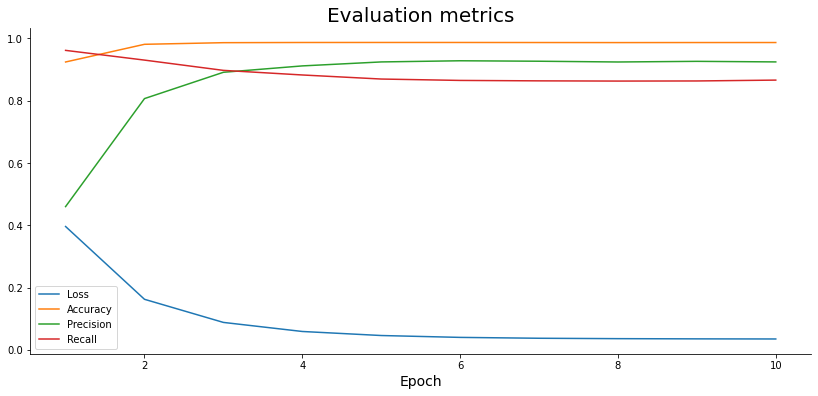

In [32]:
plt.figure()
plt.plot(
    np.arange(1, epochs + 1), 
    history.history['loss'], label='Loss'
)
plt.plot(
    np.arange(1, epochs + 1), 
    history.history['accuracy'], label='Accuracy'
)
plt.plot(
    np.arange(1, epochs + 1), 
    history.history['precision'], label='Precision'
)
plt.plot(
    np.arange(1, epochs + 1), 
    history.history['recall'], label='Recall'
)
plt.title('Evaluation metrics', size=20)
plt.xlabel('Epoch', size=14)
plt.legend()
pass

In [33]:
predictions = model.predict(x_test)

111/351 [========>.....................] - ETA: 0s

2022-06-28 16:21:19.020224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


351/351 [==============================] - 0s 1ms/step


In [34]:
prediction_classes = [
    1 if prob > 0.5 else 0 for prob in np.ravel(predictions)
]

from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, prediction_classes))

from sklearn.metrics import accuracy_score, precision_score, recall_score

print(f'Accuracy: {accuracy_score(y_test, prediction_classes):.4f}')
print(f'Precision: {precision_score(y_test, prediction_classes):.4f}')
print(f'Recall: {recall_score(y_test, prediction_classes):.4f}')


[[10418    52]
 [  103   645]]
Accuracy: 0.9862
Precision: 0.9254
Recall: 0.8623


In [35]:
pred = [int(np.round(predictions)[i][0]) for i in range(len(predictions))]

In [36]:
def check_accuracy(predictions, labels, x):
    e_nvertices = x.T[0]
    e_sum = x.T[1]
    plt.figure(figsize=(10, 8))
    mask11 = (np.array(predictions) == 1) & (np.array(labels) == 1)
    plt.scatter(e_nvertices[mask11], e_sum[mask11], c = 'dodgerblue', label = 'correct, complete', s=3) 
    mask01 = (np.array(predictions) == 0) & (np.array(labels) == 1)
    plt.scatter(e_nvertices[mask01], e_sum[mask01], c = 'lawngreen', label = 'incorrect (predicted incomplete)', s=10) 
    mask10 = (np.array(predictions) == 1) & (np.array(labels) == 0)
    plt.scatter(e_nvertices[mask10], e_sum[mask10], c = 'forestgreen', label = 'incorrect (predicted complete)', s=10) 
    #print(np.where(mask10==True))
    mask00 = (np.array(predictions) == 0) & (np.array(labels) == 0)
    plt.scatter(e_nvertices[mask00], e_sum[mask00], c = 'darkblue', label = 'correct, incomplete', s=3) 

    plt.title("Number of vertices vs total energy")
    plt.xlabel("Number of vertices")
    plt.ylabel("Total energy")
    plt.yscale('log')
    plt.legend()
    return

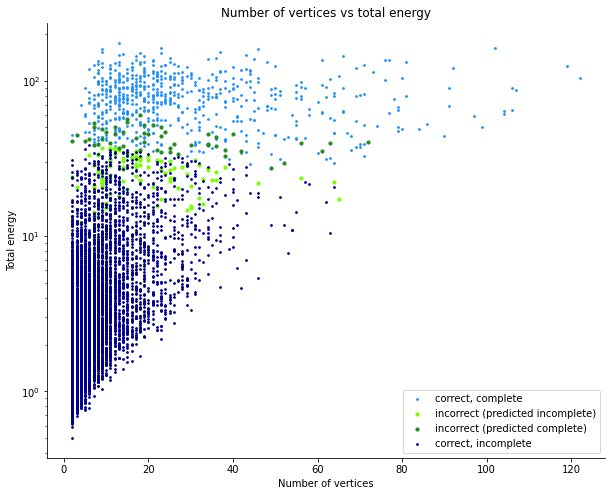

In [37]:
check_accuracy(pred, y_test, X_test)

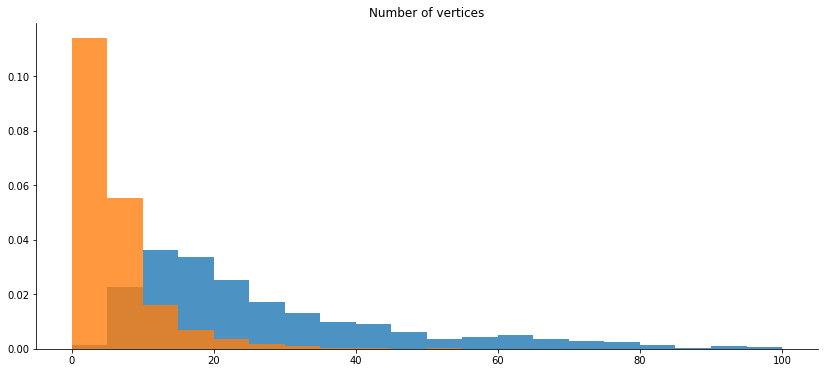

In [38]:
mask = np.array(y_test).astype(bool)
pos = X_test[mask].T[0]
plt.hist(pos, bins=20, alpha=0.8, density=True, range=(0, 100))

mask2 = np.array(y_test).astype(bool) == False
neg = X_test[mask2].T[0]
plt.hist(neg, bins=20, alpha=0.8, density=True, range=(0, 100))
plt.title("Number of vertices")
pass

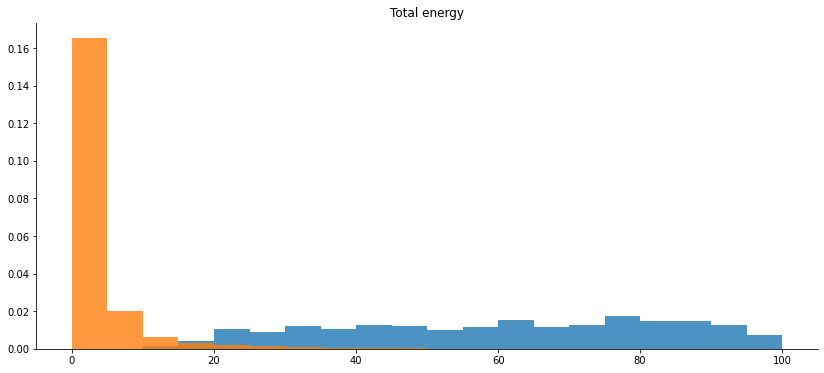

In [39]:
mask = np.array(y_test).astype(bool)
pos = X_test[mask].T[1]
plt.hist(pos, bins=20, alpha=0.8, density=True, range=(0, 100))

mask2 = np.array(y_test).astype(bool) == False
neg = X_test[mask2].T[1]
plt.hist(neg, bins=20, alpha=0.8, density=True, range=(0, 100))
plt.title("Total energy")
pass